In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

In [4]:
import numpy as np
import pandas as pd
import scipy

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/tooth_growth_csv')

In [6]:
print(data)

     len supp  dose
0    4.2   VC   0.5
1   11.5   VC   0.5
2    7.3   VC   0.5
3    5.8   VC   0.5
4    6.4   VC   0.5
5   10.0   VC   0.5
6   11.2   VC   0.5
7   11.2   VC   0.5
8    5.2   VC   0.5
9    7.0   VC   0.5
10  16.5   VC   1.0
11  16.5   VC   1.0
12  15.2   VC   1.0
13  17.3   VC   1.0
14  22.5   VC   1.0
15  17.3   VC   1.0
16  13.6   VC   1.0
17  14.5   VC   1.0
18  18.8   VC   1.0
19  15.5   VC   1.0
20  23.6   VC   2.0
21  18.5   VC   2.0
22  33.9   VC   2.0
23  25.5   VC   2.0
24  26.4   VC   2.0
25  32.5   VC   2.0
26  26.7   VC   2.0
27  21.5   VC   2.0
28  23.3   VC   2.0
29  29.5   VC   2.0
30  15.2   OJ   0.5
31  21.5   OJ   0.5
32  17.6   OJ   0.5
33   9.7   OJ   0.5
34  14.5   OJ   0.5
35  10.0   OJ   0.5
36   8.2   OJ   0.5
37   9.4   OJ   0.5
38  16.5   OJ   0.5
39   9.7   OJ   0.5
40  19.7   OJ   1.0
41  23.3   OJ   1.0
42  23.6   OJ   1.0
43  26.4   OJ   1.0
44  20.0   OJ   1.0
45  25.2   OJ   1.0
46  25.8   OJ   1.0
47  21.2   OJ   1.0
48  14.5   OJ   1.0


Do not try this at home...

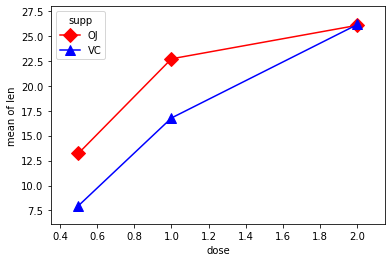

In [12]:
fig = interaction_plot(data.dose, data.supp, data.len,
             colors=['red','blue'], markers=['D','^'], ms=10)

In [26]:
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)

In [29]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov


eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)

                      sum_sq    df          F        PR(>F)    eta_sq  \
C(supp)           205.350000   1.0  15.571979  2.311828e-04  0.059484   
C(dose)          2426.434333   2.0  91.999965  4.046291e-18  0.702864   
C(supp):C(dose)   108.319000   2.0   4.106991  2.186027e-02  0.031377   
Residual          712.106000  54.0        NaN           NaN       NaN   

                 omega_sq  
C(supp)          0.055452  
C(dose)          0.692579  
C(supp):C(dose)  0.023647  
Residual              NaN  


The long and winding rode of manual calculations

In [33]:
N = len(data.len)
df_a = len(data.supp.unique()) - 1
df_b = len(data.dose.unique()) - 1
df_axb = df_a*df_b 
df_w = N - (len(data.supp.unique())*len(data.dose.unique()))

In [34]:
grand_mean = data['len'].mean()

In [35]:
ssq_a = sum([(data[data.supp ==l].len.mean()-grand_mean)**2 for l in data.supp])

In [36]:
ssq_b = sum([(data[data.dose ==l].len.mean()-grand_mean)**2 for l in data.dose])

In [37]:
ssq_t = sum((data.len - grand_mean)**2)

In [38]:
vc = data[data.supp == 'VC']
oj = data[data.supp == 'OJ']
vc_dose_means = [vc[vc.dose == d].len.mean() for d in vc.dose]
oj_dose_means = [oj[oj.dose == d].len.mean() for d in oj.dose]

In [39]:
ssq_w = sum(((oj.len - oj_dose_means)**2) + sum((vc.len - vc_dose_means)**2))

In [40]:
ssq_axb = ssq_t-ssq_a-ssq_b-ssq_w

In [41]:
# Mean Square A
ms_a = ssq_a/df_a

# Mean Square B
ms_b = ssq_b/df_b

# Mean Square AxB
ms_axb = ssq_axb/df_axb

# Mean Square Within/Error/Residual
ms_w = ssq_w/df_w

In [42]:
# F-ratio A
f_a = ms_a/ms_w
# F-ratio B
f_b = ms_b/ms_w
# F-ratio AxB
f_axb = ms_axb/ms_w

In [43]:
p_a = stats.f.sf(f_a, df_a, df_w)
p_b = stats.f.sf(f_b, df_b, df_w)
p_axb = stats.f.sf(f_axb, df_axb, df_w)

In [44]:
results = {'sum_sq':[ssq_a, ssq_b, ssq_axb, ssq_w],
           'df':[df_a, df_b, df_axb, df_w],
           'F':[f_a, f_b, f_axb, 'NaN'],
            'PR(&gt;F)':[p_a, p_b, p_axb, 'NaN']}
columns=['sum_sq', 'df', 'F', 'PR(&gt;F)']
aov_table1 = pd.DataFrame(results, columns=columns,
                          index=['supp', 'dose', 
                          'supp:dose', 'Residual'])

In [45]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov
eta_squared(aov_table1)
omega_squared(aov_table1)
aov_table1

,sum_sq,df,F,PR(&gt;F),eta_sq,omega_sq
supp,205.350000,1,1.07241,0.305016,0.059484,0.003805
dose,2426.434333,2,6.33587,0.00337446,0.702864,0.560823
supp:dose,-9519.710000,2,-24.8577,1,-2.757570,-2.717758
Residual,10340.135000,54,NaN,NaN,NaN,NaN


Using statsmodels

In [46]:
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)

In [47]:
eta_squared(aov_table)
omega_squared(aov_table)
aov_table.round(3)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(supp),205.350,1.0,15.572,0.000,0.059,0.055
C(dose),2426.434,2.0,92.000,0.000,0.703,0.693
C(supp):C(dose),108.319,2.0,4.107,0.022,0.031,0.024
Residual,712.106,54.0,NaN,NaN,NaN,NaN


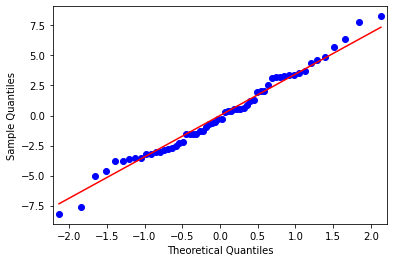

In [48]:
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()